In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv('GBPUSD_open_5year.csv')

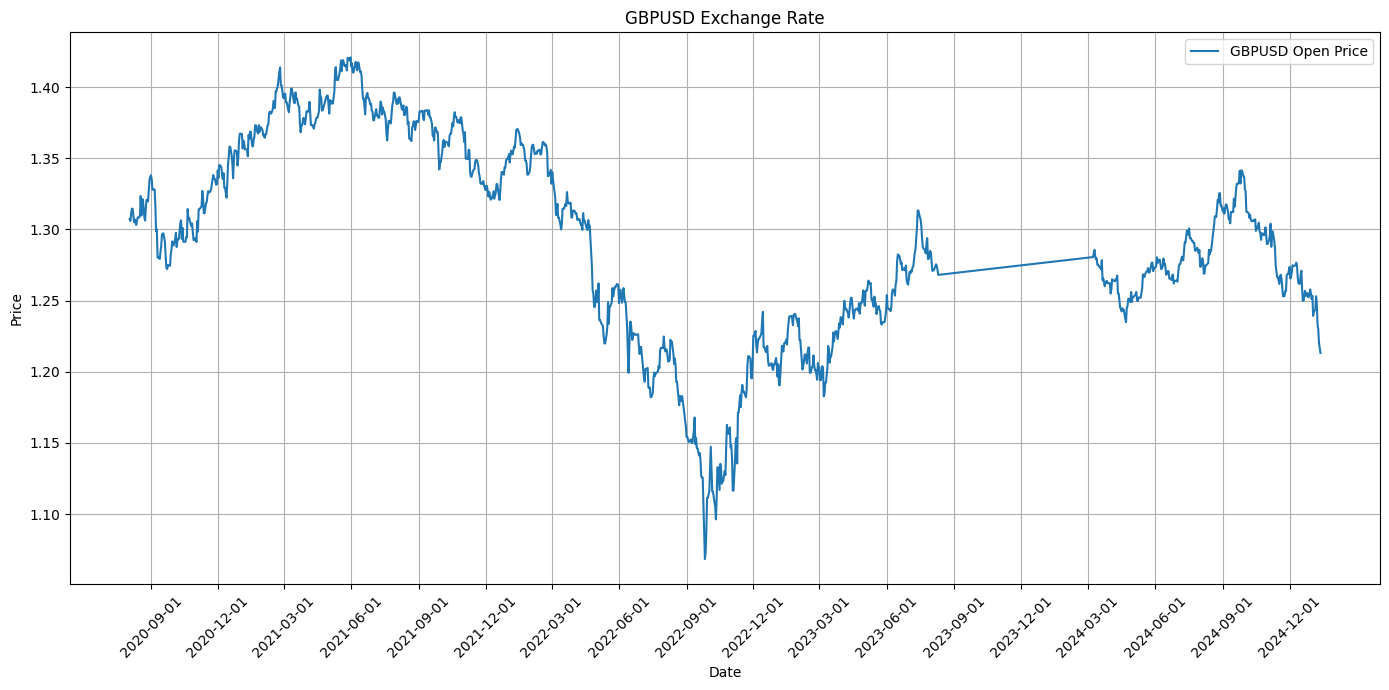

In [3]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", inplace=True)


plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Open'], label='GBPUSD Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GBPUSD Exchange Rate')


plt.xticks(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='3MS'))


plt.xticks(rotation=45)


plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)

test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

print(f"Training Data: {train_data.shape}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")


Training Data: (840, 3)
Validation Data: (180, 3)
Test Data: (180, 3)


In [6]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(df[['Open', 'Time']])
scaler = MinMaxScaler(feature_range=(0, 1))  
scaler.fit(train_data[['Open', 'Time']])  # Fit only on training data

MinMaxScaler()

In [7]:
target = 'Open'
y_val = val_data[target].values
y_test = test_data[target].values
y_train = train_data[target].values

In [8]:
X_train = scaler.transform(train_data[['Open', 'Time']])
X_val = scaler.transform(val_data[['Open', 'Time']])
X_test = scaler.transform(test_data[['Open', 'Time']])

X_train = X_train.reshape(-1, 2)
X_val = X_val.reshape(-1, 2)
X_test = X_test.reshape(-1, 2)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (840, 2)
Shape of X_val: (180, 2)
Shape of X_test: (180, 2)


## Default parameter trained model 

In [9]:
#build model
default_model = Sequential()

default_model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
default_model.add(Dense(units=32, activation='relu'))
default_model.add(Dense(units=16, activation='relu'))
default_model.add(Dense(units=8, activation='relu'))
default_model.add(Dense(units=4, activation='relu'))

# Output layer
default_model.add(Dense(units=1))

default_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

default_history = default_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

default_test_loss = default_model.evaluate(X_test, y_test)
print(f"Test Loss (DNN): {default_test_loss}")

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1386 - mae: 1.0437 - mse: 1.1386 - val_loss: 0.0054 - val_mae: 0.0652 - val_mse: 0.0054
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0348 - mae: 0.1584 - mse: 0.0348 - val_loss: 0.0798 - val_mae: 0.2681 - val_mse: 0.0798
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - mae: 0.0706 - mse: 0.0092 - val_loss: 0.0880 - val_mae: 0.2834 - val_mse: 0.0880
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - mae: 0.0605 - mse: 0.0055 - val_loss: 0.0721 - val_mae: 0.2550 - val_mse: 0.0721
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mae: 0.0567 - mse: 0.0047 - val_loss: 0.0623 - val_mae: 0.2356 - val_mse: 0.0623
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - mae: 0.0511 - mse: 0.0039 - val_loss: 0.0608 - val_mae: 0.2325 - val_mse: 0.0608
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - mae: 0.0466 - mse: 0.0033 - val_loss:

In [10]:
#build model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
    
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

tuner = kt.Hyperband(build_model, objective='val_mse', factor=3, directory='my_dir', project_name='gbpusd conversion')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hps}")




Reloading Tuner from my_dir\gbpusd conversion\tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000002465D844970>


In [11]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters and Metrics:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)  # Ensure `build` only gets `best_hps`


best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=32)

Best Hyperparameters and Metrics:
num_layers: 5
units_0: 32
units_1: 512
units_2: 96
units_3: 480
units_4: 256
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6971 - mae: 0.7041 - mse: 0.6971
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0163 - mae: 0.1069 - mse: 0.0163
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - mae: 0.0581 - mse: 0.0048
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0466 - mse: 0.0032
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0381 - mse: 0.0022
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0325 - mse: 0.0017
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0308 - mse: 0.0015
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012       
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━

In [12]:

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(np.column_stack((y_pred, np.zeros(y_pred.shape))))[:, 0]
    y_test_actual = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros(y_test.shape))))[:, 0]

    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)
    mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100 
    print(f"{model_name} Performance on Test Data:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    

evaluate_model(best_model, X_test, y_test, "Hyper tuned Model")
evaluate_model(default_model, X_test, y_test, "Base Model")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Hyper tuned Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0491
Mean Squared Error (MSE): 0.0024
R² Score: -29.2337
Mean Absolute Percentage Error (MAPE): 3.23%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Base Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0280
Mean Squared Error (MSE): 0.0008
R² Score: -9.0246
Mean Absolute Percentage Error (MAPE): 1.84%


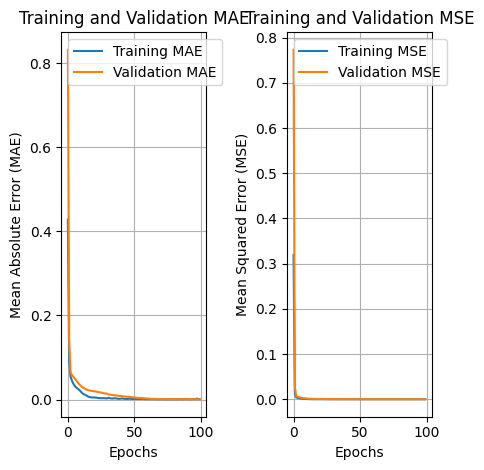

In [13]:
# Plotting


# history_dict = history.history

# #Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.plot(history_dict['loss'], label='Training Loss')
# plt.plot(history_dict['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss (MSE)')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.grid(True)

def plot_history(best_history, default_history):
    best_history_dict = best_history.history
    default_history_dict = default_history.history

        #MAE
    plt.subplot(1, 3, 2)
    plt.plot(best_history_dict['mae'], label='Training MAE')
    # plt.plot(best_history_dict['val_mae'], label='Training MAE')
    plt.plot(default_history_dict['mae'], label='Validation MAE')
    # plt.plot(default_history_dict['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)

    #MSE
    plt.subplot(1, 3, 3)
    plt.plot(best_history_dict['mse'], label='Training MSE')
    # plt.plot(best_history_dict['val_mse'], label='Training MSE')
    plt.plot(default_history_dict['mse'], label='Validation MSE')
    # plt.plot(default_history_dict['val_mse'], label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(best_history, default_history)
